# Setup

In [2]:
import sys
import os.path as op
import shutil
import warnings
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import statsmodels.api as sm
import nibabel as nib

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

sys.path.append("/Users/dschonhaut/code/style")
from colors import get_colors
co, palettes = get_colors()

sys.path.append("/Users/dschonhaut/code")
from general.array import array_operations as aop
from general.basic.helper_funcs import *
import general.nifti.nifti_ops as nops

%matplotlib inline
mpl.rcParams['font.sans-serif'] = "Helvetica"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams["grid.linewidth"] = 0.1
mpl.rcParams["grid.alpha"] = 0.75
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["grid.linewidth"] = 0.1
mpl.rcParams["grid.alpha"] = 0.75
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["xtick.major.width"] = 0.8
mpl.rcParams["ytick.major.width"] = 0.8
colors = [
    "2E45B8",
    "F97A1F",
    "3EBCD2",
    "FF4983",
    "1DC9A4",
    "B38FE7",
    "F9C31F",
    "E3120B",
]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler("color", colors)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.formatter.offset_threshold"] = 2
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.labelpad"] = 8
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = False
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["legend.loc"] = "upper right"
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.titlesize"] = 16
mpl.rcParams["figure.figsize"] = (10, 4)
mpl.rcParams["figure.subplot.wspace"] = 0.25
mpl.rcParams["figure.subplot.hspace"] = 0.25
mpl.rcParams["savefig.format"] = "pdf"
mpl.rcParams["pdf.fonttype"] = 42
font = {"tick": 6, "label": 7, "title": 8}
colws = {1: 2.05, 2: 3.125, 3: 6.45}

from importlib import reload
import colors
reload(colors)
from colors import get_colors
co, palettes = get_colors()

## Define functions

In [5]:
def map_fsroi(hem, fsroi):
    """Map fsrois label to suvr and vol cols in the ready_dataset df."""
    suvr_suffix = "_MRIBASED_SUVR"
    vol_suffix = "_ClustSize"

    if fsroi.lower() == "amygdala":
        if hem.lower() == "l":
            hemout = "Left"
        elif hem.lower() == "r":
            hemout = "Right"
        else:
            raise ValueError(f"hemisphere must be 'L' or 'R', not {hem}")
        roiout = "Amygdala"
        hemroiout = f"{hemout}_{roiout}"
    else:
        if hem.lower() == "l":
            hemout = "lh"
        elif hem.lower() == "r":
            hemout = "rh"
        else:
            raise ValueError(f"hemisphere must be 'L' or 'R', not {hem}")
        roiout = fsroi
        hemroiout = f"ctx_{hemout}_{roiout}"

    suvr_col = f"{hemroiout}{suvr_suffix}"
    vol_col = f"{hemroiout}{vol_suffix}"
    return suvr_col, vol_col

## Import data

In [105]:
# Import the data.
proj_dir = op.join(op.expanduser("~"), "box/projects/leads_tau_spread")

# ------------------------------------
# Get paths to relevant directories.
ssheet_dir = op.join(proj_dir, "data", "ssheets")
fig_dir = op.join(proj_dir, "figs")

# Load fsrois.
fsrois = pd.read_csv(op.join(ssheet_dir, "fsrois.csv"))
fsrois["leads_suvr"], fsrois["leads_vol"] = zip(*fsrois.apply(lambda x: map_fsroi(x["hem"], x["fsroi"]), axis=1))

# Load ROI data.
tau_pred = pd.read_csv(op.join(ssheet_dir, "mod-long-full_2023-07-23.csv"))

print(f"fsrois: {fsrois.shape}")
print(f"tau_pred: {tau_pred.shape}")

fsrois: (70, 20)
tau_pred: (5173, 9)


In [156]:
roi = "ipc"
_tau_pred = tau_pred.query("(roi=='{}')".format(roi)).reset_index(drop=True)

print(f"_tau_pred: {_tau_pred.shape}")

_tau_pred: (311, 9)


In [157]:
xstep = 0.01
xstart = 1.2
xstop = 3
xy = _tau_pred.query("({}>=suvr_bl_re>={})".format(xstop, xstart)).sort_values("suvr_bl_re")[["suvr_bl_re", "fit"]].values

times = [0]
for i in range(xy.shape[0]-1):
    rate = np.mean((xy[i, 1], xy[i+1, 1]))
    dur = xstep / rate
    times.append(dur)
times = np.array(times)

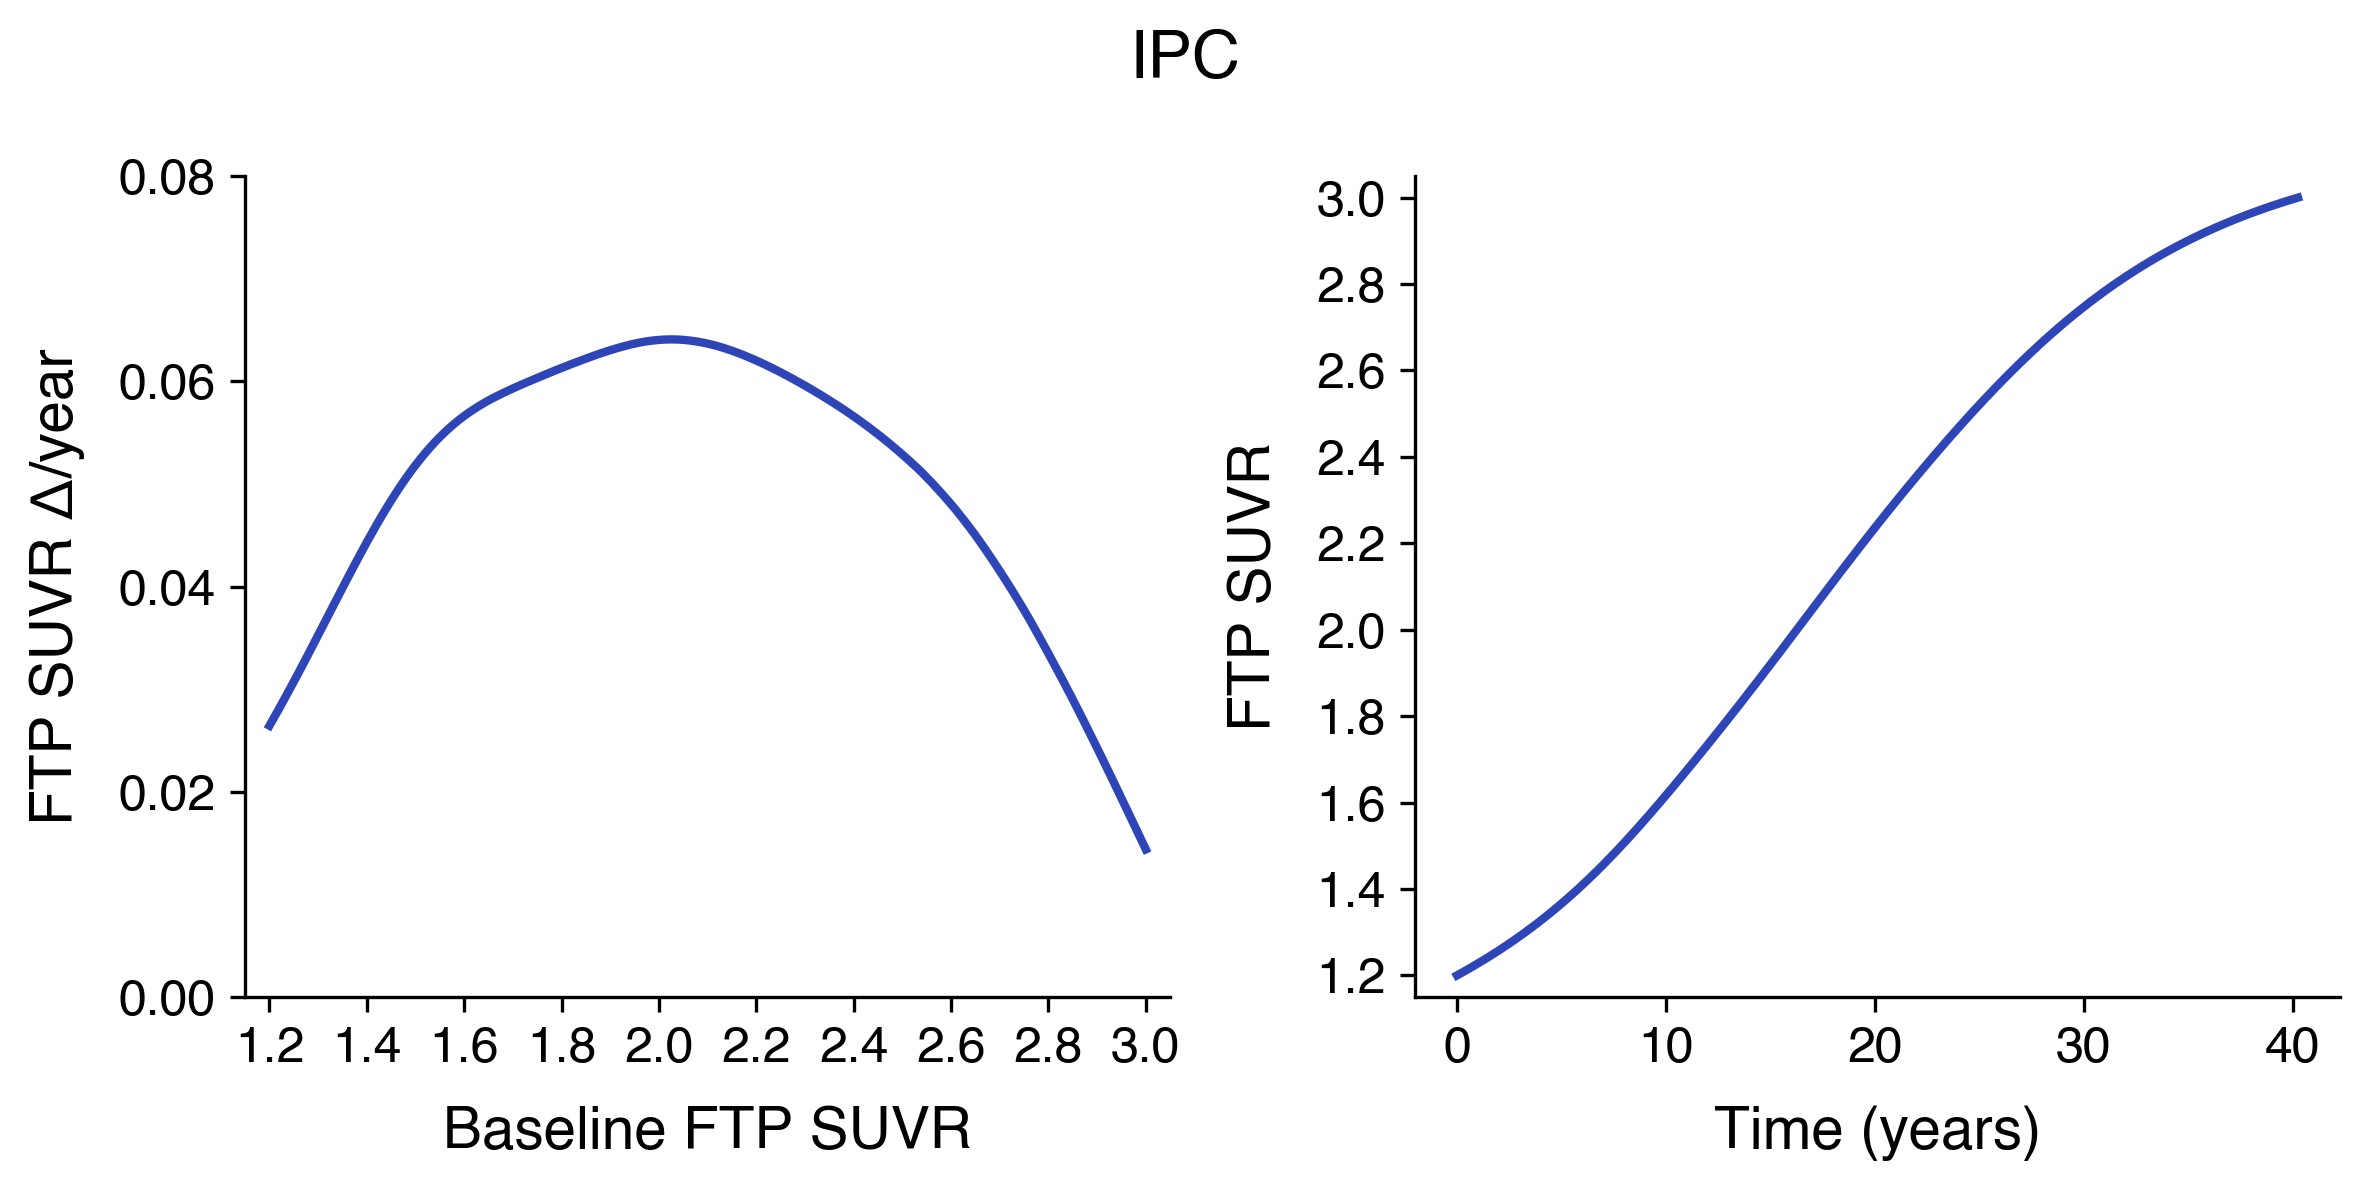

In [173]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.plot(xy[:, 0], xy[:, 1], color=co["b"], linewidth=2)
_ax.set_xlim(1.15, 3.05)
_ax.set_xticks(np.arange(1.2, 3.01, 0.2))
_ax.set_xlabel("Baseline FTP SUVR")
_ax.set_ylim(0, 0.08)
_ax.set_yticks(np.arange(0, 0.081, 0.02))
_ax.set_ylabel("FTP SUVR Δ/year")

iax = 1
_ax = ax[iax]
_ax.plot(np.cumsum(times), xy[:, 0], color=co["b"], linewidth=2)
_ax.set_xlabel("Time (years)")
_ax.set_ylim(1.15, 3.05)
_ax.set_yticks(np.arange(1.2, 3.01, 0.2))
_ax.set_ylabel("FTP SUVR")

fig.suptitle(roi.upper())
fig.tight_layout()

In [26]:
from scipy.integrate import odeint, solve_ivp

In [103]:
def _deriv(t, y):
    """Return the derivative."""
    t0 = 1.2
    y0 = np.trunc(y * 10) / 10
    y1 = np.round(y0 + 0.1, 1)
    xprop = (y - y0) / (y1 - y0)
    y0 = _tau_pred.set_index("suvr_bl_re")["fit"][y0]
    y1 = _tau_pred.set_index("suvr_bl_re")["fit"][y1]
    return y0 + (xprop * (y1 - y0))

In [104]:
t_span = np.array([1.2, 5])
y0 = np.array([_tau_pred.set_index("suvr_bl_re")["fit"][t_span[0]]])
fun = _deriv

result = solve_ivp(_deriv, t_span, y0)

KeyError: "None of [Index([0.0], dtype='float64', name='suvr_bl_re')] are in the [index]"

/var/folders/c6/3jkgtnm96jqdyqv_gqr__hy00000gp/T/ipykernel_80630/1969146896.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


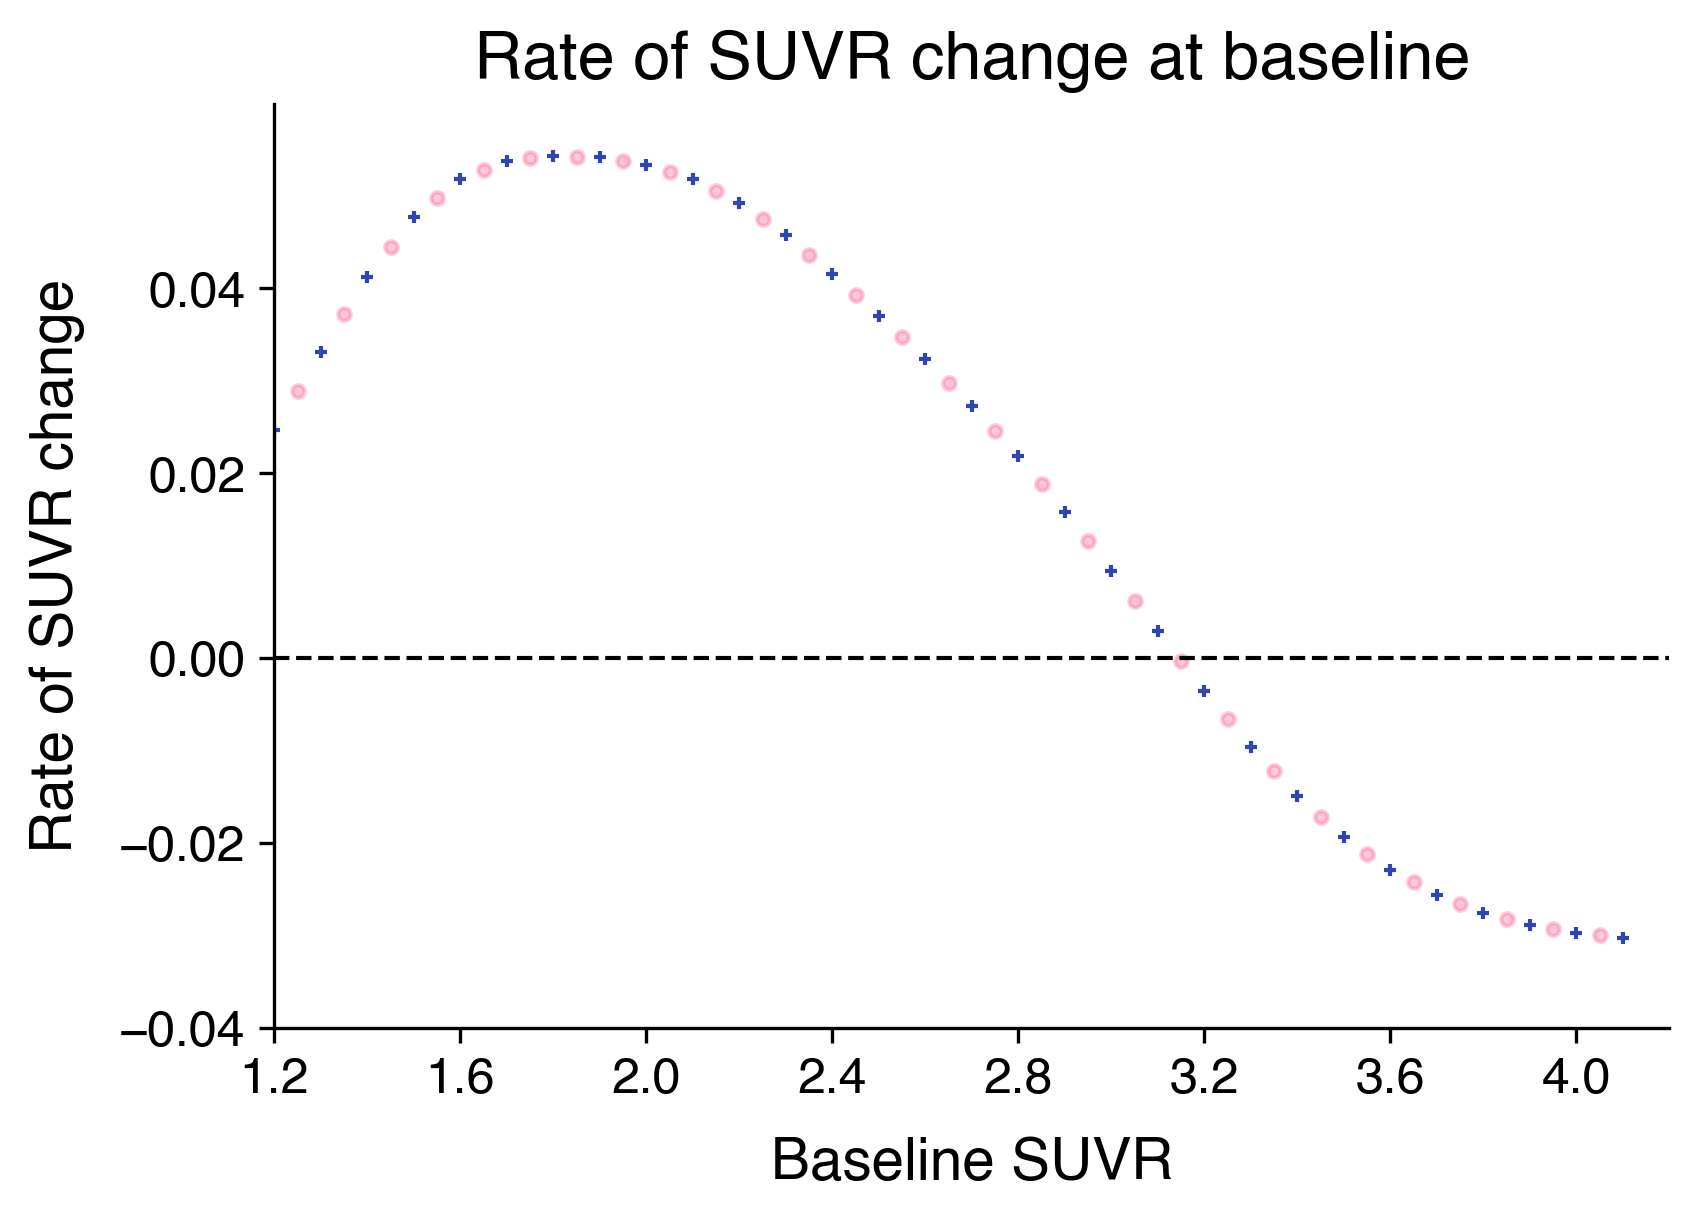

In [89]:
# Set seed
np.random.seed(0)
xvals = np.sort(1.2 + (np.random.rand(30) * (4.1-1.2)))
yvals = np.array([_deriv(0, xvals[i]) for i in range(len(xvals))])

xvals = np.sort(_tau_pred["suvr_bl_re"].values)[:-1] + 0.05
yvals = np.array([_deriv(0, xvals[i]) for i in range(len(xvals))])

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(_tau_pred["suvr_bl_re"], _tau_pred["fit"], "+", color=co["b"], linewidth=0.5)
ax.plot(xvals, yvals, "o", color=co["p"], alpha=0.3, ms=3)
ax.set_xlabel("Baseline SUVR")
ax.set_ylabel("Rate of SUVR change")
ax.set_title("Rate of SUVR change at baseline")
ax.set_xlim(1.2, 4.2)
ax.set_xticks(np.arange(1.2, 4.21, 0.4))
ax.set_ylim(-0.04, 0.06)
ax.set_yticks(np.arange(-0.04, 0.06, 0.02))
ax.axhline(0, color="k", linestyle="--", linewidth=1)
fig.show()